# Chapter 4


In [1]:
using FundamentalsNumericalComputation

┌ Info: verify download of index files...
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\MatrixDepot.jl:117
┌ Info: reading database
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:24


┌ Info: adding metadata...
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:68


┌ Info: adding svd data...
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:70
┌ Info: writing database
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\download.jl:75


┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot C:\Users\rjljr\.julia\packages\MatrixDepot\lGEHe\src\MatrixDepot.jl:119


This notebook contains my notes on chapter 4 "Rootfinding". The chapter is about finding the roots of a function, i.e. finding the values of $x$ for which $f(x) = 0$.  Unlike previous chapters, in this chapter we consider the case were $f$ is *nonlinear*.

## 4.1 The rootfinding problem

Given a continuous scalar function $f$ of a scalar variable, find a real number $r$, called a **root**, such that $f(r)=0$.

Since $f$ is nonlinear we cannot expect to solve this in a finite number of operations. However numerical solutions are well known. Julia has NLsolve package that has `nlsolve` for general purpose root-finding

The condition number of rootfinding is:

$$
\kappa = \frac{1}{|f'(x)|}
$$

This makes sense that if the function is quite flat, changing the value of $x$ will not change $f$ much and so the error (residual $f(x)$) will not be sensitive to $x$.

### Exercise 4.1.4
The most easily observed properties of the orbit of a celestial body around the sun are the period $\tau$ and the elliptical eccentricity $\epsilon$. (A circle has $\epsilon=0$.) From these, it is possible to find at any time $t$ the angle $\theta(t)$ made between the body's position and the major axis of the ellipse. This is done through
  
$$
\tan \frac{\theta}{2} = \sqrt{\frac{1+\epsilon}{1-\epsilon}}\,
\tan \frac{\psi}{2},
$$

where the eccentric anomaly $\psi(t)$ satisfies Kepler's equation:
  
$$
\psi - \epsilon \sin \psi - \frac{2\pi t}{\tau} = 0.
$$

The second equation must be solved numerically to find $\psi(t)$, and then the first can be solved analytically to find $\theta(t)$.

The asteroid Eros has $\tau=1.7610$ years and $\epsilon=0.2230$. Using `nlsolve` make a plot of $\theta(t)$ for 100 values of $t$ between $0$ and $\tau$, which is one full orbit. (Note: Use `mod(θ,2π)` to put the angle between 0 and $2\pi$ if you want the result to be a continuous function.)

In [2]:
τ = 1.7610
ϵ = 0.2230

function phi_f(ϕ, t, τ, ϵ)
    return ϕ  - 2*π*t/τ- ϵ*sin(ϕ)
end

function θ(ϕ, τ, ϵ)
    tan_theta_2 = sqrt((1-ϵ)/(1+ϵ))*tan(ϕ/2)
    theta =  2*atan(tan_theta_2)
    return mod(theta, 2*π)
end
     
s = nlsolve(x -> phi_f(x[1], 0.6, τ, ϵ), [0.0], ftol = 1e-14)
s.zero

1-element Vector{Float64}:
 2.3061534782765105

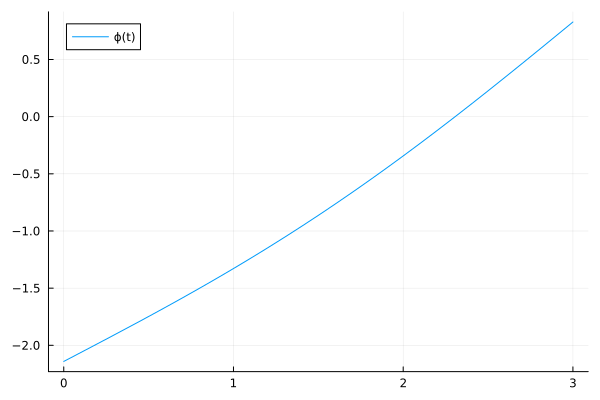

In [3]:
plot(x -> phi_f(x, 0.6, τ, ϵ), 0, 3, label = "ϕ(t)", legend = :topleft)

The rootfinding for this case seems pretty stable so I will just press ahead:

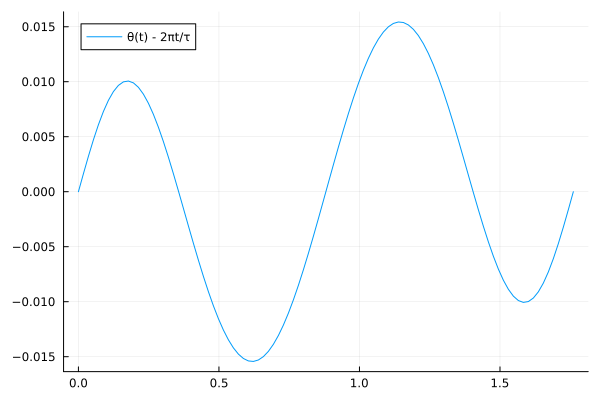

In [4]:
ts = range(0, τ, length = 100)

function find_phi(t)
    s = nlsolve(x -> phi_f(x[1], t, τ, ϵ), [0.0], ftol = 1e-14)
    s.zero[1]
end

phi_s = [find_phi(t) for t in ts]

thetas = [θ(phi, τ, ϵ) for phi in phi_s]

# difference between straight line and actual theta:
diff  = thetas - ts*2*π/τ
plot(ts, diff, label = "θ(t) - 2πt/τ", legend = :topleft)

## 4.3 Newton's method 

Newtons method is an iterative (fixed point) method of finding the roots of a function. It is based on the idea of using the tangent line to approximate the function and then finding the root of the tangent line. This is repeated until convergence.

This idea can be expressed as:

$$
x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}
$$

The text also discusses the convergence of this algorithm, and explains that it is quadratic:

$$
\lim_{k\to\infty} \frac{|x_{k+1}-r|}{|x_k-r|^2} = \frac{|f''(r)|}{2|f'(r)|}
$$

(when it converges)

## 4.4 Interpolation-based methods.

The requirement to evaluate both $f$ and $f'$ at each step of Newton's method can be a problem. This section discusses methods that only require $f$ to be evaluated.

### Secant method

The secant method is a modification of Newton's method that approximates the derivative using a finite difference:

$$
x_{k+1} = x_k - f(x_k)\frac{x_k-x_{k-1}}{f(x_k)-f(x_{k-1})}
$$

This method is not guaranteed to converge, but the convergence is superlinear when it does converge.  Superlinear convergence is defined as:

$$
\lim_{k\to\infty} \frac{|x_{k+1}-r|}{|x_k-r|^\alpha} = L
$$

for some constant $L>0$ and $\alpha > 1$.

It can be shown using Taylor series that the secant method has $\alpha = \frac{1+\sqrt{5}}{2} \approx 1.618$.

The secant method can be generalized (as shown in the text) to use higher order interpolation. I am not going to reproduce that here however.

### Bracketing

If $f$ is continuous on $[a,b]$ and $f(a)f(b) < 0$ then there is a root in the interval. This is called bracketing the root.  So it makes sense to maintain not just an individual estimate on each iteration but also an interval that contains the root. 

## 4.5 Newton for nonlinear systems

Newton's method can be generalized to find the roots of a system of equations.  The idea is to use the multivariate Taylor series to approximate the function and then find the root of the approximation.  This is repeated until convergence.

The algorithm is:

* Given $\mathbf{f}$ and a starting value $\mathbf{x}_0$:

   1. Compute $\mathbf{y}_k = \mathbf{f}(\mathbf{x}_k)$ and $J_k = J_f(x_k)$ (where $J_f$ is the Jacobian of $f$)

   2. Solve the linear system $J_k \mathbf{s}_k = -\mathbf{y}_k$ for $\mathbf{s}_k$

   3. Set $\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{s}_k$

## 4.6 Quasi-Newton methods

The Newton method requires the Jacobian to be computed at each step.  This can be expensive.  Quasi-Newton methods approximate the Jacobian using finite differences.  

One approach is just to use finite differences to approximate the Jacobian at each step, using some small interval $\delta = \sqrt{\epsilon_{\text{mach}}}$.  (The reasons for the square root are to be explained in chapter 5)

### Broyden's method
The Broyden method uses a shortcut to avoid recomputing the entire Jacobian at each step.  It uses the fact that the Jacobian is only needed to solve a linear system.  So it uses the previous Jacobian and the previous solution to the linear system to approximate the new Jacobian.  I am not going to go into the derivation, but the update formula is (where $\mathbf{A}_k$ is the current approximation of the Jacobian.)

$$
\mathbf{A}_{k+1} = \mathbf{A}_k + \frac{\mathbf{y}_{k+1} - \mathbf{y}_k - \mathbf{A}_k \mathbf{s}_k}{\mathbf{s}_k^T \mathbf{s}_k} \mathbf{s}_k^T
$$

In practice finite differences is used to kick this off and also whenever the update stops making progress.

### Levenberg method

The text discusses the Levenberg algorithm which uses a parameter $\lambda$ to control the tradeoff between Newton's method and gradient descent.  It uses an acceptance - rejection criterion to decide whether to accept the step or not, and adjusts $\lambda$ accordingly.

 I am not going to go into the details here, and this algorithm is usually modified to get the Levenberg-Marquardt algorithm.

## 4.7 Nonlinear least squares

Given a function $\mathbf{f(x)}$ mapping from $\real^n$ to $\real^m$ the *nonlinear least-squares* problem is to find $\mathbf{x}\in\real^n$ such that $\bigl\|\mathbf{f}(\mathbf{x})\bigr\|_2$ is minimized.

We consider only overdetermined problems $m > n$.

### Gauss-Newton method

As usual, we can solve this by substituting a linear model for $\mathbf{f}$ at the current estimate $\mathbf{x}_k$:

$$
\mathbf{q}(\mathbf{x}) = \mathbf{f}(\mathbf{x}_k) + A_k(\mathbf{x}-\mathbf{x}_k)
$$

Where $A_k$ is the exact Jacobian or some approximation as described earlier.

This leads to the Gauss Newton method:

Given $\mathbf{f}$ and a starting value $\mathbf{x}_1$, for each $k=1,2,3,\ldots$

1. Compute $\mathbf{y}_k = \mathbf{f}(\mathbf{x}_k)$ and $\mathbf{A}_k$, the exact or approximate Jacobian matrix at $\mathbf{x}_k$.
2. Solve the linear least squares problem $\argmin \| \mathbf{A}_k\mathbf{s}_k  + \mathbf{y}_k\|_2$ for $\mathbf{s}_k$.
3. Let $\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{s}_k$.

The text states that the convergence can be quite slow when the minimum is not close to zero.


### Nonlinear data fitting.

Consider some data $\{t_i,y_i\}_{i=1}^m$ and a model $\mathbf{g}(t,\mathbf{x})$ where $\mathbf{x}$ is a vector of parameters.

We can find the 'best' parameters by defining a *misfit* function for our model $\mathbf{g}$ and minimize the misfit:

$$
\mathbf{f}(\mathbf{x}) = \left[\, g(t_i,\mathbf{x})-y_i  \, \right]_{\,i=1,\ldots,m}
$$

### Exercise 4.7.3

 A famous result by Kermack and McKendrick in 1927   suggests that in epidemics that kill only a small fraction of a susceptible population, the death rate as a function of time is well modeled by

$$
w'(t) = A \text{sech}^2[B(t-C)]
$$
  
for constant values of the parameters $A,B,C$. Since the maximum of sech is $\operatorname{sech}(0)=1$, $A$ is the maximum death rate and $C$ is the time of peak deaths. You will use this model to fit the deaths per week from plague recorded in Mumbai during 1906:

``` 
5, 10, 17, 22, 30, 50, 51, 90, 120, 180, 292, 395, 445, 775, 780,
700, 698, 880, 925, 800, 578, 400, 350, 202, 105, 65, 55, 40, 30, 20
```

**(a)** Use levenberg method (defined in 4.6.4) to find the best least-squares fit to the data using the  model. Make a plot of the model fit superimposed on the data. 

**(b)** Repeat part (a) using only the first 15 data values.

In [13]:
data = [5, 10, 17, 22, 30, 50, 51, 90, 120, 180, 292, 395, 445, 775, 780,
700, 698, 880, 925, 800, 578, 400, 350, 202, 105, 65, 55, 40, 30, 20];
t = 1:length(data)

1:30

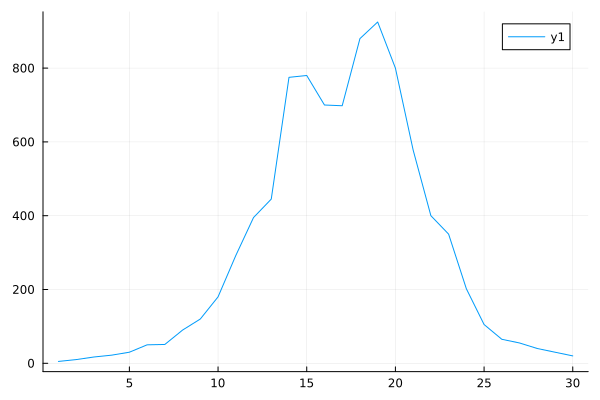

In [14]:
plot(t, data)

In [20]:
function model(A, B, C, t)
    return @. A*sech(B*(t - C))^2
end

function misfit(x)
    A, B, C = x
    return @. model(A, B, C, t) - data
end

misfit (generic function with 1 method)

For guesses , the max is around 800, so A = 800. THe peak is around 15, so C = 15. B seems to effect the width, i will start it at 1.

In [36]:
fit = FNC.levenberg(x -> misfit(x), [800, 1.0, 15])

17-element Vector{Vector{Float64}}:
 [800.0, 1.0, 15.0]
 [789.1948986343145, -0.1417943920789142, 14.99701488442909]
 [773.6591146318996, -0.16142760881586904, 17.6433974989222]
 [783.4540477020848, -0.1664603381436071, 17.681920024944688]
 [848.3354151198097, -0.19334818056146427, 17.36513397598841]
 [865.3783162243662, -0.19310621731393354, 17.286470668601456]
 [878.8007870260631, -0.19097543927735736, 17.27679454104829]
 [881.0301130213127, -0.18774657556241442, 17.341182168736378]
 [882.8964767245851, -0.18855392325972903, 17.337823374858505]
 [882.4608607499385, -0.1884836823534455, 17.337837423398845]
 [882.6152321794549, -0.18850908359033067, 17.33783833331009]
 [882.6183980651244, -0.18843458010093256, 17.33900362252382]
 [882.6541472696157, -0.18844987319125714, 17.33890982665126]
 [882.6396224864648, -0.18844750475954145, 17.338909920673608]
 [882.6464312432909, -0.1884486157162488, 17.33890988130859]
 [882.6486240121276, -0.18844751096024986, 17.338930543941476]
 [882.648624

In [37]:
best = last(fit)

3-element Vector{Float64}:
 882.6486240121276
  -0.18844751096055362
  17.338930543941473

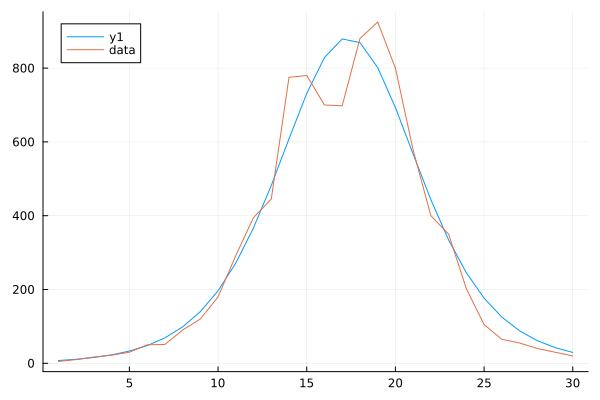

In [38]:
model_res = model(best[1],best[2], best[3],t)
plot(t, model_res)
plot!(t, data, label = "data", legend = :topleft)

We note that the sign of B doesn't matter

For second part, we are assuming we are earlier in the pandemic and having to see if we can predict the peak.

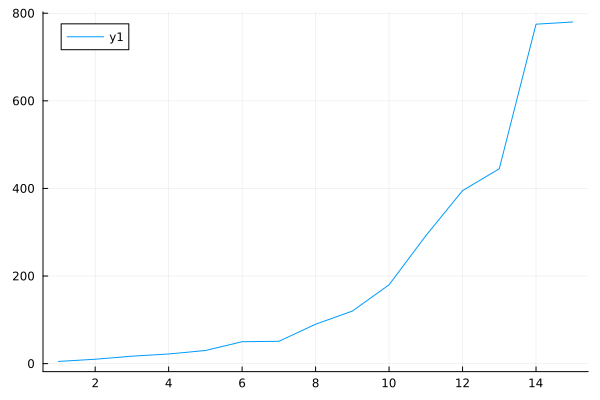

In [41]:
data2 = data[1:15]
t2 = 1:length(data2)
plot(t2,data2)

I will use a larger guess for A that is pesimistic.

In [43]:

function misfit2(x)
    A, B, C = x
    return @. model(A, B, C, t2) - data2
end

fit2 = FNC.levenberg(x -> misfit2(x), [1000, 1.0, 20])

29-element Vector{Vector{Float64}}:
 [1000.0, 1.0, 20.0]
 [1000.0000633194117, 0.34924007499746557, 19.87337331564924]
 [1000.0000988362243, -0.3259410718060094, 19.847613083714656]
 [1000.0000603085034, 0.244402537633171, 19.863633666424345]
 [1000.0000725835918, 0.10960792858652338, 19.858297538689463]
 [1000.000091169211, 0.14717116472743513, 19.851842592322154]
 [1000.0003260742876, 0.13313944104944814, 19.815588873210444]
 [1000.0010641355525, 0.1376538426949093, 19.72093965861392]
 [1000.0066448590438, 0.1502329833058635, 19.005758959692578]
 [1000.021190839392, 0.18530176685371563, 17.181936456051986]
 ⋮
 [878.9906809796779, 0.22502792686005943, 16.282001620293293]
 [879.0197601063771, 0.22502235300808718, 16.282224014745463]
 [879.0098279420055, 0.22502425663501105, 16.282148045699405]
 [879.004645147673, 0.22504323883210967, 16.281850603556723]
 [878.9958472657684, 0.22504625363656588, 16.28176270321468]
 [879.0042157207478, 0.22504465080967304, 16.281826656055802]
 [879.00051

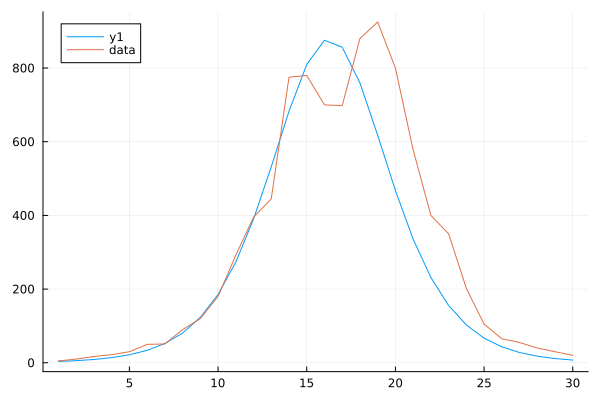

In [44]:
best2 = last(fit2)

model_res2 = model(best2[1],best2[2], best2[3],t)
plot(t, model_res2)
plot!(t, data, label = "data", legend = :topleft)

Seems to do really well with the limited data!